In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class Actor(nn.Module):

    def __init__(self, state_dim,  action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out

In [3]:
class Critic(nn.Module):

    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [4]:
env = gym.make("CartPole-v1")
env.seed(0)

[0]

In [5]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

In [31]:
episode_rewards = []
episode_num=1000

stats={'actor loss':[], 'critic loss':[], 'return':[]}
for i in range(episode_num):
    done = False
    total_reward = 0
    state = env.reset()
    env.seed(0)

    while not done:
        
        probs = actor(torch.from_numpy(state).float())
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float()) - critic(torch.from_numpy(state).float())                                   
                                             
        total_reward += reward
        state = next_state

        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
    stats['actor loss'].append(actor_loss)
    stats['critic loss'].append(critic_loss)
    stats['return'].append(total_reward)
            
    episode_rewards.append(total_reward)

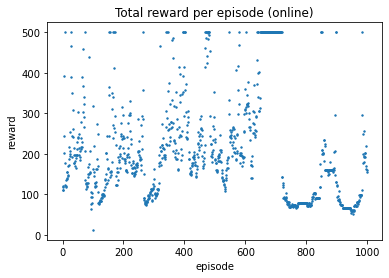

In [32]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [33]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

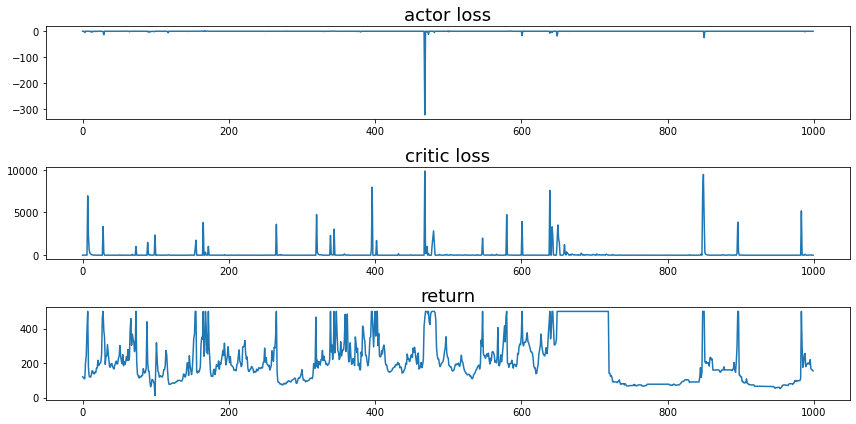

In [34]:
plot_stats(stats)

In [35]:
env = gym.make("CartPole-v1")
total_reward=0
done=False
env.seed(0)
state= env.reset()
print(state)
while not done:
    action = actor(torch.from_numpy(state).float())
    dist = torch.distributions.Categorical(probs=action)
    action = dist.sample()
    next_state, reward, done, info = env.step(action.detach().numpy())
    state = next_state
    total_reward+=reward   
    
    #env.render()
print(total_reward)
#env.close()

[-0.04456399  0.04653909  0.01326909 -0.02099827]
154.0
